In [1]:
# ----- LIBS

# geoprocessamento
import geopandas as gpd
from shapely.geometry import Polygon

# normalizar
import numpy as np
from shapely.geometry import mapping
from sklearn.preprocessing import MinMaxScaler

# plots
import matplotlib.pyplot as plt

# gerar e visualizar csv
import csv
import pandas as pd

# Roteiro

**O objetivo desse notebook é criar 2 datasets: o de prédios da Unicamp e o de posicionamento dos coletores no Campus.** 

Para isso, as seguintes etapas foram seguidas:

- Extração de shapes e plots da Unicamp
- Conversão de CRS
- Normalização de Mapa da Unicamp
- Remoção de prédios externos
- Tramento de Dados Faltantes
    - Buscar e Mapear prédios **!!!!**
    - Criar e ADD shapes de prédios não encontrados
    - Criar pontos não encontrados
- Criação de dataset dos Prédios da Unicamp
    - Criação de dataset (xml)
- Criação de dataset do posicionamento dos Coletores
    - Rotular Prédios 
    - ADD pontos não encontrados
    - Criação de dataset (csv)

**Os datasets gerados serão utilizados como entradas para as simulações LoRaWAN feitas no simulador NS3**

**!!!!** Essa etapa do notebook foi utilizada em outras etapas do roteiro tb (ex: Remoção de prédios externos) 

# Extração de shapes e Plots da Unicamp

- Extração de região geográfica de interesse (bbbike) no formato .shp
- Plot de shapes

In [2]:
# Apontando para o path do dataset da Unicamp
import os

current_path = os.getcwd()
# print(current_path.find('obstacle_exp'))
# print(current_path[0:current_path.find('obstacle_exp')])

map_dataset_path = current_path[:current_path.find('obstacle_exp')]
building_shp_path = "unicamp-shapefiles-dataset/shape/buildings.shp"
roads_shp_path = "unicamp-shapefiles-dataset/shape/roads.shp"

unicamp_building_dataset_path = map_dataset_path + building_shp_path
unicamp_roads_dataset_path = map_dataset_path + roads_shp_path

In [3]:
# ----- READ BUILDING SHAPES DATASET

# use bbbike to obtain shape files
# bbbike: https://extract.bbbike.org/

# Unicamp Shapes:
# landuse
# natural
# places
# points
# railways
# roads
# waterways
# buildings

unicamp_df = gpd.read_file(unicamp_building_dataset_path)
unicamp_roads_df = gpd.read_file(unicamp_roads_dataset_path)

print('shape:', unicamp_df.shape)
unicamp_df.head()

shape: (509, 4)


,osm_id,name,type,geometry
0,95011154,IC 3,university,"POLYGON ((-47.06377 -22.81368, -47.06375 -22.8..."
1,95011157,Banco Santander,bank,"POLYGON ((-47.06880 -22.81689, -47.06881 -22.8..."
2,95011161,Ciclo Básico II,university,"POLYGON ((-47.07069 -22.81797, -47.07050 -22.8..."
3,95011169,IC - Instituto de Computação,university,"POLYGON ((-47.06520 -22.81481, -47.06452 -22.8..."
4,95011172,IC 3.5,university,"POLYGON ((-47.06422 -22.81356, -47.06417 -22.8..."


In [4]:
# ----- CHECK BUILDING SHAPES DATASET CRS

# crs - sistema referência de coordenadas

# WGS 84 - sistema de coords mundial (degree)
unicamp_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

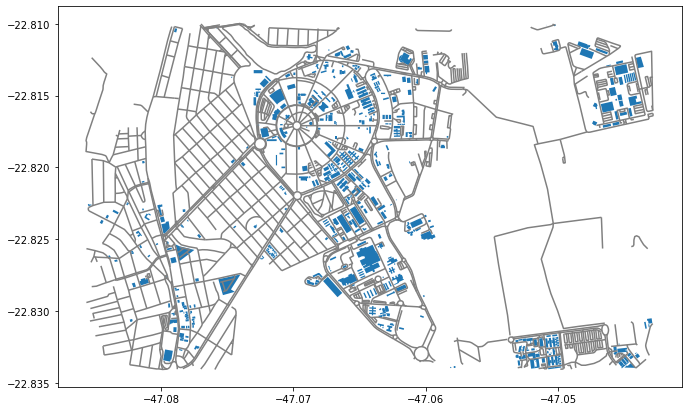

In [5]:
# ----- Plot UNICAMP MAPA (WGS84)
ax = unicamp_df.plot(figsize=(15, 7))
unicamp_roads_df.plot(ax=ax, figsize=(15, 7), color='gray')

,osm_id,name,type,geometry
3,95011169,IC - Instituto de Computação,university,"POLYGON ((-47.06520 -22.81481, -47.06452 -22.8..."


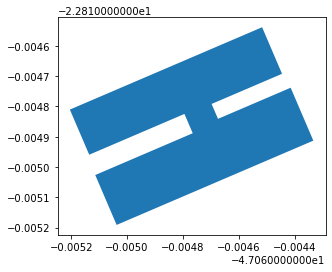

In [6]:
# ----- PLOT IC BUILDING (WGS84)
ic_predio = unicamp_df.query('osm_id == 95011169')
ax = ic_predio.plot()
ic_predio.head()

# Conversão de CRS

Conversão de CRS WGS 84 para SIRGAS 2000 / UTM zone 23S , que é dado em metros e representa o sistemas de georeferência das Américas.

Características:

- Datum: SIRGAS 2000
- Projeção: UTM zone 23S (Campinas/SP)
- América Latina
- Hemisfério sul. 

Referências:
- https://epsg.io/31981
- https://spatialreference.org/ref/?search=31981
- https://pt.slideshare.net/JorgeSantos30/20141011-qgis24-sistemadereferenciadecoordenadas
- https://ocefpaf.github.io/python4oceanographers/blog/2013/12/16/utm/
- https://cursos.alura.com.br/forum/topico-erro-ao-reprojetar-usando-a-funcao-to_crs-77139


In [7]:
# Geodataframe dos Prédios da Unicamp
unicamp_df = gpd.read_file(unicamp_building_dataset_path)
unicamp_df.head(10)

,osm_id,name,type,geometry
0,95011154,IC 3,university,"POLYGON ((-47.06377 -22.81368, -47.06375 -22.8..."
1,95011157,Banco Santander,bank,"POLYGON ((-47.06880 -22.81689, -47.06881 -22.8..."
2,95011161,Ciclo Básico II,university,"POLYGON ((-47.07069 -22.81797, -47.07050 -22.8..."
3,95011169,IC - Instituto de Computação,university,"POLYGON ((-47.06520 -22.81481, -47.06452 -22.8..."
4,95011172,IC 3.5,university,"POLYGON ((-47.06422 -22.81356, -47.06417 -22.8..."
5,95011175,DAC - Diretoria Acadêmica do Campus,university,"POLYGON ((-47.07073 -22.81754, -47.07051 -22.8..."
6,95463718,Restaurante Universitário,restaurant,"POLYGON ((-47.07236 -22.81793, -47.07183 -22.8..."
7,95463720,GMU - Ginásio Multidisciplinar,university,"POLYGON ((-47.07183 -22.81502, -47.07153 -22.8..."
8,95463721,None,None,"POLYGON ((-47.06819 -22.81501, -47.06789 -22.8..."
9,95463722,Instituto de Filosofia e Ciencias Humanas,university,"POLYGON ((-47.06806 -22.81536, -47.06853 -22.8..."


In [8]:
# Conversão de WSG84 para SIRGAS 2000 / UTM one 23S : 31983
# Zona 23 inclui Campinas
# https://spatialreference.org/ref/epsg/31983/

unicamp_utm_df = unicamp_df.to_crs(31983)
unicamp_utm_df.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - 48°W to 42°W
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

,osm_id,name,type,geometry
0,95011154,IC 3,university,"POLYGON ((288179.970 7475626.000, 288182.081 7..."
1,95011157,Banco Santander,bank,"POLYGON ((287668.651 7475263.188, 287667.599 7..."
2,95011161,Ciclo Básico II,university,"POLYGON ((287476.147 7475140.737, 287495.256 7..."
3,95011169,IC - Instituto de Computação,university,"POLYGON ((288034.700 7475498.723, 288104.976 7..."
4,95011172,IC 3.5,university,"POLYGON ((288134.073 7475638.141, 288139.036 7..."
5,95011175,DAC - Diretoria Acadêmica do Campus,university,"POLYGON ((287471.903 7475188.530, 287494.612 7..."
6,95463718,Restaurante Universitário,restaurant,"POLYGON ((287305.221 7475143.279, 287359.092 7..."
7,95463720,GMU - Ginásio Multidisciplinar,university,"POLYGON ((287355.264 7475465.824, 287386.481 7..."
8,95463721,None,None,"POLYGON ((287728.526 7475472.273, 287759.847 7..."
9,95463722,Instituto de Filosofia e Ciencias Humanas,university,"POLYGON ((287742.863 7475434.026, 287693.507 7..."


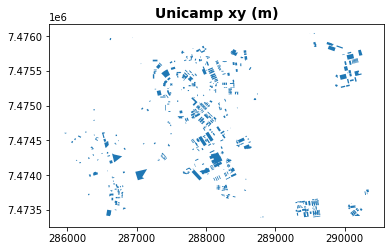

In [9]:
# Plot de mapa Convertido para SIRGAS 2000 / UTM zone 23S
ax = unicamp_utm_df.plot()
plt.title('Unicamp xy (m)',fontweight='bold',fontsize=14)

# Dataframe convertido
unicamp_utm_df.head(10)

In [10]:
unicamp_utm_df['centroids'] = unicamp_utm_df.centroid
unicamp_utm_df['centroids']

0      POINT (288164.757 7475614.484)
1      POINT (287680.703 7475257.946)
2      POINT (287463.109 7475182.762)
3      POINT (288079.758 7475493.426)
4      POINT (288158.099 7475640.063)
                    ...              
504    POINT (288473.227 7474421.359)
505    POINT (288491.927 7474443.209)
506    POINT (286688.852 7474451.339)
507    POINT (286696.551 7474453.636)
508    POINT (289447.856 7473449.118)
Name: centroids, Length: 509, dtype: geometry

In [11]:
unicamp_utm_df.head()

,osm_id,name,type,geometry,centroids
0,95011154,IC 3,university,"POLYGON ((288179.970 7475626.000, 288182.081 7...",POINT (288164.757 7475614.484)
1,95011157,Banco Santander,bank,"POLYGON ((287668.651 7475263.188, 287667.599 7...",POINT (287680.703 7475257.946)
2,95011161,Ciclo Básico II,university,"POLYGON ((287476.147 7475140.737, 287495.256 7...",POINT (287463.109 7475182.762)
3,95011169,IC - Instituto de Computação,university,"POLYGON ((288034.700 7475498.723, 288104.976 7...",POINT (288079.758 7475493.426)
4,95011172,IC 3.5,university,"POLYGON ((288134.073 7475638.141, 288139.036 7...",POINT (288158.099 7475640.063)


# Normalização de Mapa da Unicamp

In [12]:
# Bounds of Unicamp Map
unicamp_minx, unicamp_miny, unicamp_maxx, unicamp_maxy = unicamp_utm_df.geometry.total_bounds

print('bounds:', unicamp_minx, unicamp_miny, unicamp_maxx, unicamp_maxy)
print('x:', unicamp_maxx-unicamp_minx)
print('y:', unicamp_maxy- unicamp_miny)


bounds: 285960.71918678837 7473387.272237044 290348.567447891 7476048.738107968
x: 4387.848261102627
y: 2661.465870924294


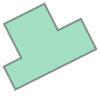

In [13]:
# get all geometries of unicamp_utm_df
unicamp_geometries = [i for i in unicamp_utm_df.geometry]

# geometry example
unicamp_geometries[0]

In [14]:
map_minx = 1e+10
map_maxx = -1
map_miny = 1e+10
map_maxy = -1

for geometry in range(len(unicamp_geometries)):
    
    # get all coordinates (x,y) of polygons in unicamp_utm_df
    all_coords_per_geometry = mapping(unicamp_geometries[geometry])["coordinates"] 

    # split all coordinates per geometry and get x coords and y coords
    x_coords = [all_coords_per_geometry[0][i][0] for i in range(len(all_coords_per_geometry[0]))]
    y_coords = [all_coords_per_geometry[0][i][1] for i in range(len(all_coords_per_geometry[0]))]
    
    # convert to 2D array
    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)
    
    # get all geometry coords in x and y
    if geometry == 0:
        all_coords_x = x_coords.copy()
        all_coords_y = y_coords.copy()
    else:
        all_coords_x = np.append (all_coords_x, x_coords.copy(), axis=0)
        all_coords_y = np.append (all_coords_y, y_coords.copy(), axis=0)
        
    # get bounds limits of map and compare with unicamp_utm_df.geometry.total_bounds
    # after for loop, limits must be equal
    if np.min(x_coords) < map_minx:
        map_minx = np.min(x_coords)
    if np.max(x_coords) > map_maxx:
        map_maxx = np.max(x_coords)
    
    if np.min(y_coords) < map_miny:
        map_miny = np.min(y_coords)
    if np.max(y_coords) > map_maxy:
        map_maxy = np.max(y_coords)
    

# after for loop, limits must be equal
print(map_minx, map_miny,map_maxx, map_maxy)
print(unicamp_minx, unicamp_miny, unicamp_maxx, unicamp_maxy)
# yey

# convert to 2D array 
x = np.array(all_coords_x).reshape(-1, 1) # reshape -> 2D array
y = np.array(all_coords_y).reshape(-1, 1)

285960.71918678837 7473387.272237044 290348.567447891 7476048.738107968
285960.71918678837 7473387.272237044 290348.567447891 7476048.738107968


In [15]:
# create a normalized map with unicamp bounds

# criando novo mapa, que conterá geometrias normalizadas
mapa_normalizado = gpd.GeoDataFrame(columns=["geometry"])
mapa_normalizado['osm_id'] = unicamp_utm_df['osm_id']
mapa_normalizado['name'] = unicamp_utm_df['name']
mapa_normalizado['type'] = unicamp_utm_df['type']

# processo de normalização
for geometry in range(len(unicamp_geometries)):

    # get all coordinates (x,y) of polygons in unicamp_utm_df
    all_coords_per_geometry = mapping(unicamp_geometries[geometry])["coordinates"] 
    
    # split all coordinates per geometry and get x coords and y coords
    x_coords = [all_coords_per_geometry[0][i][0] for i in range(len(all_coords_per_geometry[0]))]
    y_coords = [all_coords_per_geometry[0][i][1] for i in range(len(all_coords_per_geometry[0]))]
    
    # convert to 2D array
    x_coords = np.array(x_coords).reshape(-1, 1) 
    y_coords = np.array(y_coords).reshape(-1, 1)
    
    # define limits of normalization
    scaler_x = MinMaxScaler(feature_range = (0, unicamp_maxx - unicamp_minx))
    scaler_y = MinMaxScaler(feature_range = (0, unicamp_maxy - unicamp_miny))
    
    # normalize with all all geometry coords x 
    scaler_x.fit(x)
    transform_x = scaler_x.transform(x_coords)
    
    # normalize with all all geometry coords y
    scaler_y.fit(y)
    transform_y = scaler_y.transform(y_coords)
    
    # convert np array x and y normalized back to polygon
    building_geometry = np.append (transform_x, transform_y, axis=1)
    new_polygon = Polygon(building_geometry)
    
    mapa_normalizado.loc[geometry, 'geometry'] = new_polygon
    

print('Shape do Mapa normalizado:', mapa_normalizado.shape)
mapa_normalizado.head()

Shape do Mapa normalizado: (509, 4)


,geometry,osm_id,name,type
0,"POLYGON ((2219.251 2238.728, 2221.362 2239.787...",95011154,IC 3,university
1,"POLYGON ((1707.932 1875.916, 1706.879 1871.880...",95011157,Banco Santander,bank
2,"POLYGON ((1515.427 1753.464, 1534.537 1769.617...",95011161,Ciclo Básico II,university
3,"POLYGON ((2073.981 2111.450, 2144.257 2142.551...",95011169,IC - Instituto de Computação,university
4,"POLYGON ((2173.354 2250.869, 2178.317 2240.382...",95011172,IC 3.5,university


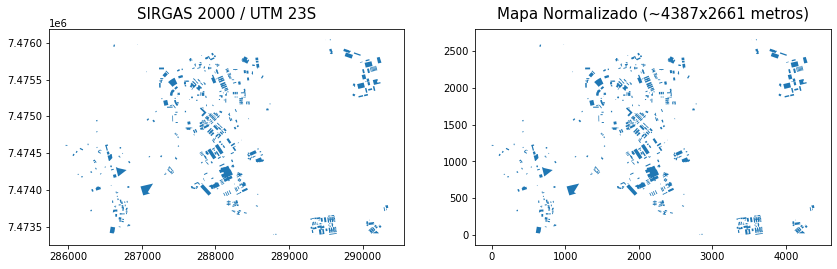

In [16]:
# ANTES E DEPOIS DA NORMALIZAÇÃO

fig, axes = plt.subplots(1,2, figsize = (14, 7)) # 1 linha, 2 colunas

# Mapa da unicamp no crs SIRGAS 2000/ UTM 23S
axes[0].set_title('SIRGAS 2000 / UTM 23S', fontsize=15, y=1.02)
unicamp_utm_df.plot(ax=axes[0])

# Mapa da Unicamp
# onde:
# - unicamp bounds = 285960.71918678837 7473387.272237044 290348.567447891 7476048.738107968
# - maxx - minx    = 4387.848261102627
# - maxy - miny    = 2661.465870924294
axes[1].set_title('Mapa Normalizado (~4387x2661 metros)', fontsize=15, y=1.02)
mapa_normalizado.plot(ax=axes[1])

plt.show()

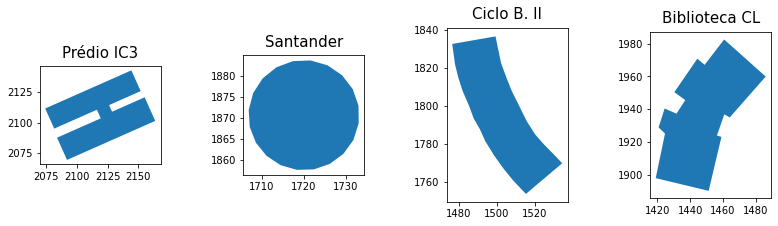

In [17]:
# EXEMPLO DE PRÉDIOS NORMALIZADOS

# get buildings
ic_predio = mapa_normalizado.query('osm_id == 95011169')
santander = mapa_normalizado.query('osm_id == 95011157')
cbII_predio = mapa_normalizado.query('osm_id == 95011161')
biblioteca = mapa_normalizado.query('osm_id == 95463723')

# plot buildings
fig, axes = plt.subplots(1,4, figsize = (12, 5)) # 2 linha, 2 colunas

# Mapa da unicamp no crs SIRGAS 2000/ UTM 23S
axes[0].set_title('Prédio IC3', fontsize=15, y=1.02)
ic_predio.plot(ax=axes[0])

axes[1].set_title('Santander', fontsize=15, y=1.02)
santander.plot(ax=axes[1])

axes[2].set_title('Ciclo B. II', fontsize=15, y=1.02)
cbII_predio.plot(ax=axes[2])

axes[3].set_title('Biblioteca CL', fontsize=15, y=1.02)
biblioteca.plot(ax=axes[3])

# space between subplots
fig.tight_layout(pad=5.0)

plt.show()

# Google Maps: https://www.google.com/maps/place/Coordenadoria+de+P%C3%B3s-gradua%C3%A7%C3%A3o+-+Instituto+de+Biologia+%2F+Unicamp/@-22.8174874,-47.069779,253m/data=!3m1!1e3!4m5!3m4!1s0x0:0x5970884374643347!8m2!3d-22.8194777!4d-47.0698417

# Remove Prédios externos ao Campus

In [18]:
mapa_normalizado.head(5)

,geometry,osm_id,name,type
0,"POLYGON ((2219.251 2238.728, 2221.362 2239.787...",95011154,IC 3,university
1,"POLYGON ((1707.932 1875.916, 1706.879 1871.880...",95011157,Banco Santander,bank
2,"POLYGON ((1515.427 1753.464, 1534.537 1769.617...",95011161,Ciclo Básico II,university
3,"POLYGON ((2073.981 2111.450, 2144.257 2142.551...",95011169,IC - Instituto de Computação,university
4,"POLYGON ((2173.354 2250.869, 2178.317 2240.382...",95011172,IC 3.5,university


<AxesSubplot:>

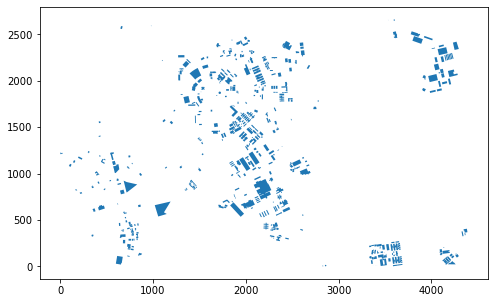

In [19]:
# filter row by osm_id
# mapa_normalizado[mapa_normalizado['osm_id'] == 95011157]

mapa_normalizado.plot(figsize=(12,5))

In [20]:
# REMOVE PRÉDIOS EXTERNOS A UNICAMP
predios_externos = [
430669816, 430669831, 430669834, 432450447, 433093651, 433113382, 433113491, 433113680, 433122921,
365923638, 365923673, 365923778, 365923845, 365923888, 152072898, 152073614, 152073616, 152073618,
152073619, 260542749, 186578257, 186578259, 258633062, 365923609, 355176010, 256659533, 355176008,
365923625, 365923635, 404611803, 404611804, 404611805, 404611806, 404611807, 404611808, 404718313,
404727748, 404727750, 430268890, 430268891, 430268893, 430268896, 430268898, 433123132, 433124150,
433124151, 433124152, 433124153, 433124154, 433124155, 433124207, 535296300, 535296301, 535296302,
535297665, 531269652, 535297666, 535297667, 535297668, 535297669, 535300979, 535300980, 535300981,
535300982, 535300983, 535300984, 535300985, 535300986, 535300987, 535313329, 535313331, 535313333,
535313335, 535313337, 535313338, 535313340, 535313342, 535313344, 535313346, 535313348, 535313350,
535324162, 535324164, 535324165, 535324163, 535324166, 535324167, 535324168, 535324169, 535324170,
535324171, 535324172, 535324173, 535324174, 535324175, 535324176, 535324177, 535324178, 535324179,
535324180, 535324181, 535324182, 535324183, 535324185, 535324186, 535324187, 535324188, 535324189,
535335892, 535335894, 535335895, 535335897, 535300988, 535335899, 535300988, 535335899, 535335900, 
535335901, 535354595, 535354596, 535335898, 535324184, 535305960, 531269049, 538743968, 538971320,
538971329, 539206917, 539211849, 539409502, 539409503, 539622003, 540438600, 540438602, 540438604, 
541342109, 556029153, 556460922, 556460927, 556460929, 556460931, 556460933, 556460935, 556460937,
556460939, 556460943, 556460944, 556460947, 556460948, 563505750, 564166303, 566854866, 566854867,
603144340, 603150725, 603150726, 626214630, 626214631, 627167444, 627167446, 627167447, 627663595,
627663596, 627663597, 627167444, 627167446, 627167447, 627663595, 627663596, 627663597, 627663598,
627798928, 627798929, 627798931, 627798933, 627798936, 627798938, 627802134, 627802135, 633390066,
633390068, 633390069, 633390071, 633390072, 633390073, 633390074, 633390075, 633390076, 633390077,
633390078, 633390079, 633390080, 633390082, 633390083, 633390084, 633390087, 633390089, 633390094,
633390096, 633390098, 633390101, 633390104, 633390105, 633390106, 633390108, 633390109, 633390110,
633390111, 633390112, 684602338, 684602339, 684602340, 694483210, 694483211, 747442134, 747442133,
792139327, 556460920, 556460945, 556460946, 556327607, 556327608
]

for predio in predios_externos:
    mapa_normalizado.drop(mapa_normalizado.index[mapa_normalizado['osm_id'] == predio], inplace = True)

# reorganizando indexes
mapa_normalizado = mapa_normalizado.reset_index(drop=True)
mapa_normalizado.head()

,geometry,osm_id,name,type
0,"POLYGON ((2219.251 2238.728, 2221.362 2239.787...",95011154,IC 3,university
1,"POLYGON ((1707.932 1875.916, 1706.879 1871.880...",95011157,Banco Santander,bank
2,"POLYGON ((1515.427 1753.464, 1534.537 1769.617...",95011161,Ciclo Básico II,university
3,"POLYGON ((2073.981 2111.450, 2144.257 2142.551...",95011169,IC - Instituto de Computação,university
4,"POLYGON ((2173.354 2250.869, 2178.317 2240.382...",95011172,IC 3.5,university


<AxesSubplot:>

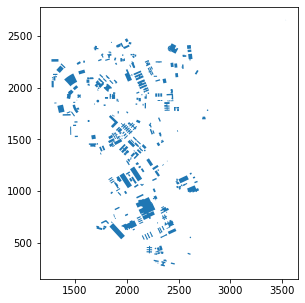

In [21]:
mapa_normalizado.plot(figsize=(12,5))

In [22]:
mapa_normalizado.shape

(295, 4)

In [23]:
mapa_normalizado.head(mapa_normalizado.shape[0])

,geometry,osm_id,name,type
0,"POLYGON ((2219.251 2238.728, 2221.362 2239.787...",95011154,IC 3,university
1,"POLYGON ((1707.932 1875.916, 1706.879 1871.880...",95011157,Banco Santander,bank
2,"POLYGON ((1515.427 1753.464, 1534.537 1769.617...",95011161,Ciclo Básico II,university
3,"POLYGON ((2073.981 2111.450, 2144.257 2142.551...",95011169,IC - Instituto de Computação,university
4,"POLYGON ((2173.354 2250.869, 2178.317 2240.382...",95011172,IC 3.5,university
...,...,...,...,...
290,"POLYGON ((2474.512 1079.559, 2492.657 1062.565...",698317156,None,university
291,"POLYGON ((2470.075 1091.371, 2476.698 1085.527...",698317157,None,university
292,"POLYGON ((2475.582 1043.396, 2479.730 1034.537...",698317158,Editora Unicamp,university
293,"POLYGON ((2500.518 1026.088, 2506.724 1013.990...",698317159,Nudecri / Labeurb,university


# Tratamento de Dados Faltantes

- **[OK]** Museu
- **[OK]** IG (parte superior do mapa)
- **[OK]** IG (parte inferior do mapa)
- **[OK]** Centro de Biologia Molecular e Engenharia Genética (CBMEG) 
- **[OK]** Centro de Computação (CCUEC) 
- **[OK]** Ciclo Básico I 
- **[OK]** Escola Estadual de Ensino Fundamental Físico Sérgio Pereira Porto (SERGIO PORTO)
- **[OK]** Grupo Gestor de Obras (GGO) 
- **[OK]** Ponto de ônibus – Rua Roxo Moreira (PO-RM)
- **[OK]** Ponto de ônibus – Avenida Adolpho Lutz (PO-AL)
- **[OK]** Ponto de ônibus – Rua Vital Brasil (PO-VB)

In [24]:
# Some useful functions

from shapely.geometry import Point
from shapely.geometry import box


ref_osm_id = int(10000000)
def add_dataset_rows(geodataset, new_polygon, name, type_building ):
    global ref_osm_id
    last_index = geodataset.shape[0]
    geodataset.loc[last_index, 'geometry'] = new_polygon
    geodataset.loc[last_index, 'osm_id'] = ref_osm_id
    geodataset.loc[last_index, 'name'] = name
    geodataset.loc[last_index, 'type'] = type_building
    ref_osm_id = int(ref_osm_id + 1)
    print("Novo Shape:", geodataset.shape)
    
    return geodataset.iloc[geodataset.shape[0]-1:geodataset.shape[0]]


def add_node_dataset_rows(geodataset, name, type_building, point):
    global ref_osm_id
    last_index = geodataset.shape[0]
    geodataset.loc[last_index, 'osm_id'] = ref_osm_id
    geodataset.loc[last_index, 'name'] = name
    geodataset.loc[last_index, 'type'] = type_building
    geodataset.loc[last_index, 'x'] = point.x
    geodataset.loc[last_index, 'y'] = point.y
    geodataset.loc[last_index, 'z'] = 1.5
    
    ref_osm_id = int(ref_osm_id + 1)
    print("Novo Shape:", geodataset.shape)
    
    return geodataset.iloc[geodataset.shape[0]-1:geodataset.shape[0]]

def get_polygon_coords (polygon):
    g = [i for i in polygon.geometry]
    x,y = g[0].exterior.coords.xy
    coords = np.dstack((x,y)).tolist()
    
    return coords


def create_circle_building(x, y, buffer):
    circle = Point(x, y).buffer(buffer) 

    print("Area:", circle.area)
    print("Length:", circle.length)
    
    return circle

def create_box_building(building_name, bounds, offset_xmin, offset_ymin, offset_xmax, offset_ymax):
    new_building = box(
        bounds[0] - offset_xmin,
        bounds[1] - offset_ymin,
        bounds[2] -offset_xmax,
        bounds[3] -offset_ymax
    )

    print("Bounds do prédio " + str(building_name) + ":", bounds)
    print("\nÁrea:", new_building.area)
    print("Length:", new_building.length)
    
    return new_building


def compare_buildings(ref_building, new_building):
    geodataset_ref = gpd.GeoSeries(ref_building)
    ax = geodataset_ref.plot(color='Gray')

    geodataset_new = gpd.GeoSeries(new_building)
    geodataset_new.plot(ax=ax) 

    
def calculate_distance(osm_id, new_polygon):
    # ----- Criação de Geodataframe para o calculo de distancia entre centroids do Museu e predio de referência (Inova)
    points_df = gpd.GeoDataFrame(columns=["geometry"])
    points_df.loc[:, 'geometry'] = mapa_normalizado.query('osm_id ==' + str(osm_id))['geometry']
    points_df.loc[0, 'geometry'] = new_polygon

    points_df['centroid'] = points_df["geometry"].centroid

    # Cálculo de Distância entre Circle centroids e cada linha do dataset
    print("Distancia entre centroids:\n", points_df.distance(new_polygon.centroid))

    return points_df

## Buscar e Mapear predios

In [25]:
# ----- RESULTADOS DO MAPEAMENTO (prédios com coletores)

# ENCONTRADOS POR CONSULTA DE NOME:
# 1. Agência de Inovação Inova Unicamp (INOVA) # 163762428
# 2. Biblioteca Central (BC) # 95463723
# 11. Ciclo Básico II # 95011161
# 14. Diretoria Geral de Recursos Humanos (DGRH) # 362643631
# 18. Faculdade de Ciências Médicas (FCM) # 537142892
# 24. Faculdade de Engenharia Elétrica e de Computação (FEEC) # 269851018
# 25. Faculdade de Engenharia Mecânica (FEM) # 554951124
# 27. Fundação de Desenvolvimento da Unicamp (FUNCAMP) # 556327623
# 32. Instituto de Biologia (IB) # 95540601
# 33. Instituto de Computação (IC) # 95011169
# 35. Instituto de Filosofia e Ciências Humanas (IFCH) # 95463722
# 39. Instituto de Matemática, Estatística e Computação Científica (IMECC) # 95463724
# 41. Prefeitura Universitária # 562047775
# 45. Restaurante Administrativo (RA) # 269851019
# 46. Restaurante Saturnino (RS) # 270488633
# 47. Restaurante Universitário (RU) # 95463718


# ENCONTRADOS POR CONSULTA DE TIPO:

# 4. Centro de Componentes Semicondutores (CCS) # 554951142
# 6. Centro de Diagnóstico de Doenças do Aparelho Digestivo (GASTROCENTRO) # 556327645 e 556327646
# 8. Centro de Hematologia e Hemoterapia (HEMOCENTRO) # 556327636
# 9. Centro para Manutenção de Equipamentos (CEMEQ) # 556327686
# 12. Coordenadoria de Desenvolvimento Cultural (CDC) # 95463720
# 13. Diretoria Geral da Administração (DGA) # 554951141
# 15. Divisão de Educação Infantil e Complementar (DEdIC) # 537155702
# 16. Engenharia Básica (EB)  # 554951142 (ccs)
# 20. Faculdade de Enfermagem (FEnf) # 537142893
# 21. Faculdade de Engenharia Agrícola (FEAGRI) # 97592693 ~
# 23. Faculdade de Engenharia de Alimentos (FEA) # 554951120 ~
# 26. Faculdade de Engenharia Química (FEQ) # 554968138
# 28. Gabinete do Reitor (GR) # 562047779
# 34. Instituto de Estudos da Linguagem (IEL) # 556327698 ~
# 40. Instituto de Química (IQ) # 96493946


# ENCONTRADOS POR SHAPES:

# 7. Centro de Estudos de Petróleo (CEPETRO) 562047735
# 19. Faculdade de Educação Física (FEF) # 96446654
# 22. Faculdade de Engenharia Civil, Arquitetura e Urbanismo (FEC) # 556327678
# 30. Hospital de Clínicas (HC) # 538334949
# 31. Instituto de Artes (IA) # 537166697
# 36. Instituto de Física Gleb Wataghin (IFGW) # 556327703
# 38. Instituto de Geociências (IG) da Avenida Érico Veríssimo (superior)-------------


# NÃO ESTÃO NO MAPA (DADOS FALTANTES - 9):

# 3. Centro de Biologia Molecular e Engenharia Genética (CBMEG) 
# 5. Centro de Computação (CCUEC) 
# 10. Ciclo Básico I 
# 17. Escola Estadual de Ensino Fundamental Físico Sérgio Pereira Porto (SERGIO PORTO)
# 29. Grupo Gestor de Obras (GGO) 
# 37. Instituto de Geociências (IG) da Rua Oswaldo Cruz (inferior) 

# Casos especiais:
# 42. Ponto de ônibus – Rua Roxo Moreira (PO-RM)
# 43. Ponto de ônibus – Avenida Adolpho Lutz (PO-AL)
# 44. Ponto de ônibus – Rua Vital Brasil (PO-VB)

In [26]:
# ----- METÓDOS DE BUSCA PARA MAPEAMENTO

# Busca por linha em todo dataset
predio = mapa_normalizado.iloc[1:2] #ex Reitoria 367-376
print(mapa_normalizado.shape)
predio.head(predio.shape[0])

# Busca por Nome
# predio = mapa_normalizado[mapa_normalizado['name'].str.contains("Restaurante",  na=False)]
# predio.head()

# Busca de todos os predios com Nome None
# predio_sem_indentificacao = mapa_normalizado[mapa_normalizado['name'].isna()]
# predio = predio_sem_indentificacao
# predio.head()

# Busca por linhas de todos os predios com Nome None
# predio_sem_indentificacao = mapa_normalizado[mapa_normalizado['name'].isna()]
# predio = predio_sem_indentificacao.iloc[47:48] # ex HC
# predio.head()

(295, 4)


,geometry,osm_id,name,type
1,"POLYGON ((1707.932 1875.916, 1706.879 1871.880...",95011157,Banco Santander,bank


In [27]:
# predio.plot(color="red")

(172.30436972156167, 2660.447316917591)

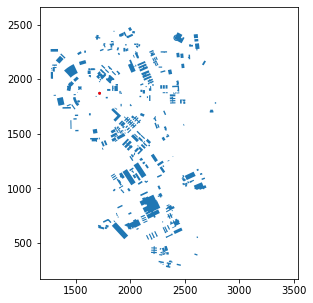

In [28]:
### ----- PLOT DE PREDIO DE ACORDO COM A BUSCA REALIZADA

ax = mapa_normalizado.plot(figsize=(12, 5))

# predios None
predio['geometry'].plot(ax=ax, color='Red')

# Para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(minx -100, maxx)
ax.set_ylim(miny -100, maxy)

## Cria e ADD shapes de prédios não encontrados

### Museu

Area: 848.7578629129567
Length: 103.31689506381134


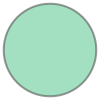

In [29]:
# ----- CRIANDO SHAPE DO MUSEU
ref_id = 386834061
circle = create_circle_building(2873, 2125, 16.45)
circle

(2050.0, 2200.0)

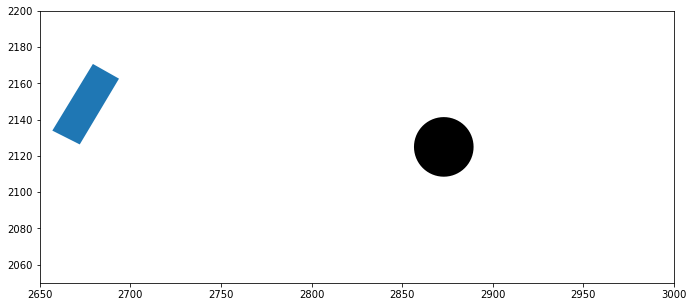

In [30]:
# -----PLOT DE MAPA NORMALIZADO E SHAPE DO MUSEU

ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))
circle_df = gpd.GeoDataFrame(columns=["geometry"])
circle_df.loc[0, 'geometry'] = circle
circle_df.plot(ax=ax, color="black")

# para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(2650, 3000)
ax.set_ylim(2050, 2200)

In [31]:
calculate_distance(ref_id, circle)

Distancia entre centroids:
 56    183.157318
0       0.000000
dtype: float64


,geometry,centroid
56,"POLYGON ((2679.359 2170.779, 2693.756 2162.661...",POINT (2675.485 2148.395)
0,"POLYGON ((2889.450 2125.000, 2889.371 2123.388...",POINT (2873.000 2125.000)


In [32]:
add_dataset_rows(mapa_normalizado, circle, 'Museu Exploratório', 'university')

Novo Shape: (296, 4)


,geometry,osm_id,name,type
295,"POLYGON ((2889.450 2125.000, 2889.371 2123.388...",10000000.0,Museu Exploratório,university


### IG (parte superior) 

197    POINT (1763.863 2311.977)
dtype: geometry

Area: 4128.9115864411
Length: 308.81519310735166


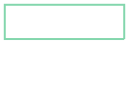

In [33]:
ref_id = 556327663
ref_polygon = mapa_normalizado.query('osm_id ==' + str(ref_id))
print(ref_polygon['geometry'].centroid)

# Get Polygon value
# get_polygon_coords(ref_polygon)

building_IG = box(1628, 2289.589499125257, 1748,2323.997095678933)

print("\nArea:", building_IG.area)
print("Length:",building_IG.length)
building_IG.boundary

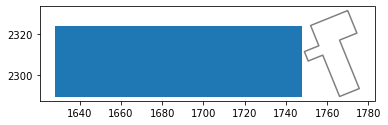

In [34]:
compare_buildings(ref_polygon['geometry'].boundary, building_IG )

(2000.0, 2660.447316917591)

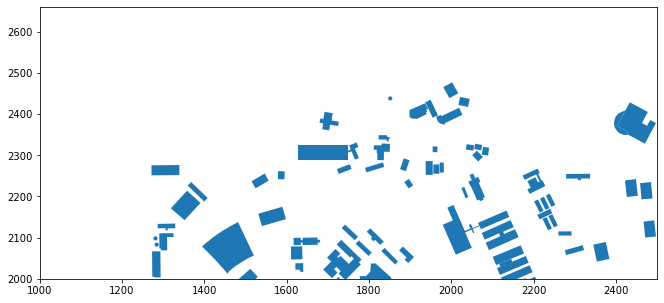

In [35]:
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))
# teste = gpd.GeoSeries(building_IG.boundary)
teste = gpd.GeoSeries(building_IG)
teste.plot(ax=ax) 

# para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(1000, 2500)
ax.set_ylim(2000, maxy)

In [36]:
add_dataset_rows(mapa_normalizado, building_IG, 'IG-cima', 'university')

Novo Shape: (297, 4)


,geometry,osm_id,name,type
296,"POLYGON ((1748.000 2289.589, 1748.000 2323.997...",10000001.0,IG-cima,university


In [37]:
mapa_normalizado.shape

(297, 4)

### CCUEC

In [38]:
ref_id = 146276265
ref_polygon = mapa_normalizado.query('osm_id ==' + str(ref_id))

# Get Polygon value
# get_polygon_coords(ref_polygon)

Bounds do prédio CCUEC: [2362.4825676369946, 1776.3833273760974, 2414.682026700757, 1839.0054074134678]

Área: 3799.285713508144
Length: 249.64307820226531


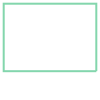

In [39]:
bounds_ref = list(ref_polygon.geometry.total_bounds)
building_CUEC = create_box_building("CCUEC", bounds_ref, 90, 0, 70, 10)
building_CUEC.boundary

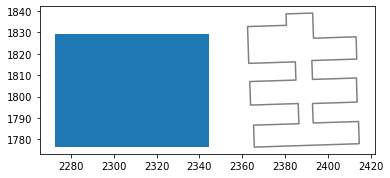

In [40]:
compare_buildings(ref_polygon['geometry'].boundary, building_CUEC )

(1400.0, 2200.0)

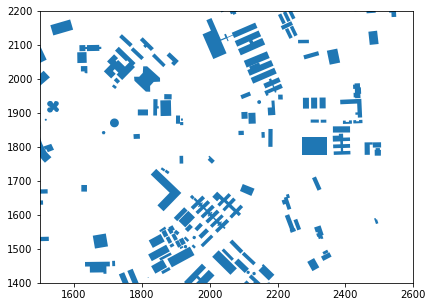

In [41]:
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))

teste = gpd.GeoSeries(building_CUEC)
teste.plot(ax=ax) 

# para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(1500, 2600)
ax.set_ylim(1400, 2200)

In [42]:
add_dataset_rows(mapa_normalizado, building_CUEC, 'CCUEC', 'university')

Novo Shape: (298, 4)


,geometry,osm_id,name,type
297,"POLYGON ((2344.682 1776.383, 2344.682 1829.005...",10000002.0,CCUEC,university


### CBMEG

In [43]:
# Prédio Ref: 537243162
ref_id = 537243162
ref_polygon = mapa_normalizado.query('osm_id ==' + str(ref_id))
# get_polygon_coords(ref_polygon)

Bounds do prédio CBMEG: [2728.4084199807257, 1694.1402587117627, 2761.934372895921, 1720.3778286511078]

Área: 893.6469494397516
Length: 133.527045709081


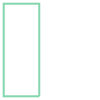

In [44]:
bounds_ref = list(ref_polygon.geometry.total_bounds)

bounds_CBMEG = create_box_building("CBMEG", bounds_ref, 60, 120, 75 , 98)
bounds_CBMEG.boundary

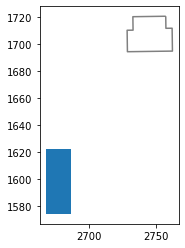

In [45]:
compare_buildings(ref_polygon['geometry'].boundary, bounds_CBMEG)

In [46]:
calculate_distance(ref_id, bounds_CBMEG )

Distancia entre centroids:
 83    108.581628
0       0.000000
dtype: float64


,geometry,centroid
83,"POLYGON ((2756.975 1720.378, 2757.099 1711.463...",POINT (2745.172 1706.394)
0,"POLYGON ((2686.934 1574.140, 2686.934 1622.378...",POINT (2677.671 1598.259)


(1400.0, 2200.0)

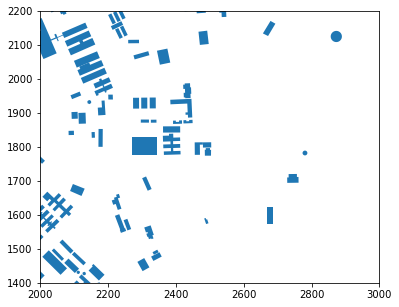

In [47]:
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))

teste = gpd.GeoSeries(bounds_CBMEG)
teste.plot(ax=ax) 

# # para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(2000, 3000)
ax.set_ylim(1400, 2200)

In [48]:
add_dataset_rows(mapa_normalizado, bounds_CBMEG, 'CBMEG', 'university')

Novo Shape: (299, 4)


,geometry,osm_id,name,type
298,"POLYGON ((2686.934 1574.140, 2686.934 1622.378...",10000003.0,CBMEG,university


### Ciclo Básico I

Area: 999.3749214289749
Length: 112.1098223032847
Area: 999.3749214289749
Length: 112.1098223032847


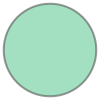

In [49]:
ref_id = 95011157
ref_polygon = mapa_normalizado.query('osm_id ==' + str(ref_id))

circle_up = create_circle_building(ref_polygon.centroid.x, ref_polygon.centroid.y - 40, 17.85)
circle_down = create_circle_building(ref_polygon.centroid.x -10 , ref_polygon.centroid.y - 75, 17.85)
circle_up

In [50]:
# circle_df = gpd.GeoDataFrame(columns=["geometry"])
# circle_df.loc[0, 'geometry'] = circle_up
# get_polygon_coords(circle_df)

(1750.0, 1875.0)

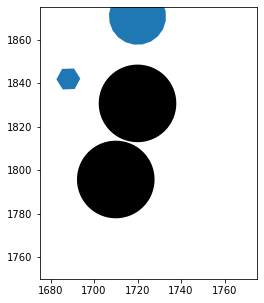

In [51]:
# -----PLOT DE MAPA NORMALIZADO E SHAPE DO MUSEU

ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))
circle_df = gpd.GeoDataFrame(columns=["geometry"])
circle_df.loc[0, 'geometry'] = circle_up
circle_df.loc[1, 'geometry'] = circle_down
circle_df.plot(ax=ax, color="black")

# para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(1675, 1775)
ax.set_ylim(1750, 1875)

In [52]:
calculate_distance(ref_id, circle_up)

Distancia entre centroids:
 1    27.057168
0     0.000000
dtype: float64


,geometry,centroid
1,"POLYGON ((1707.932 1875.916, 1706.879 1871.880...",POINT (1719.984 1870.674)
0,"POLYGON ((1737.834 1830.674, 1737.748 1828.924...",POINT (1719.984 1830.674)


In [53]:
add_dataset_rows(mapa_normalizado, circle_up, 'CBI', 'university')

Novo Shape: (300, 4)


,geometry,osm_id,name,type
299,"POLYGON ((1737.834 1830.674, 1737.748 1828.924...",10000004.0,CBI,university


### SERGIO PORTO

In [54]:
# Prédio Ref: 537155703
ref_id = 537155703
ref_polygon = mapa_normalizado.query('osm_id ==' + str(ref_id))
# get_polygon_coords(ref_polygon)

Bounds do prédio SPorto: [2363.2217046910664, 634.9975279290229, 2458.120880121889, 723.0180862415582]

Área: 3246.3407832222374
Length: 255.83946748671588


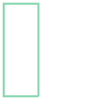

In [55]:
bounds_ref = list(ref_polygon.geometry.total_bounds)

building_SP = create_box_building("SPorto", bounds_ref, -160, -25, -100 , -30)
building_SP.boundary

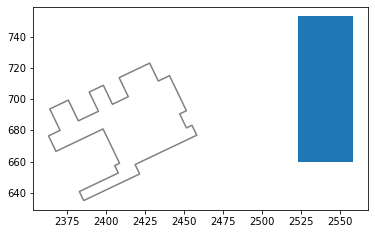

In [56]:
compare_buildings(ref_polygon['geometry'].boundary, building_SP)

In [57]:
calculate_distance(ref_id, building_SP )

Distancia entre centroids:
 77    87.71276
0      0.00000
dtype: float64


,geometry,centroid
77,"POLYGON ((2385.722 634.998, 2421.545 652.047, ...",POINT (2414.107 684.092)
0,"POLYGON ((2558.121 659.998, 2558.121 753.018, ...",POINT (2540.671 706.508)


(500.0, 1000.0)

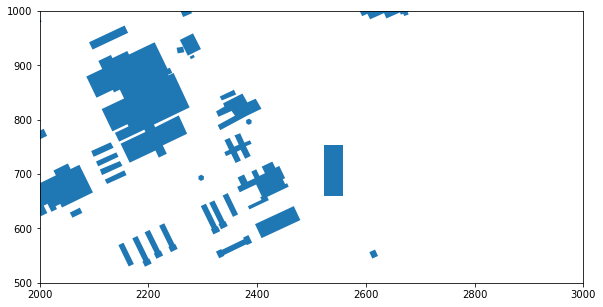

In [58]:
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))

teste = gpd.GeoSeries(building_SP)
teste.plot(ax=ax) 

# # para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(2000, 3000)
ax.set_ylim(500, 1000)

In [59]:
add_dataset_rows(mapa_normalizado, building_SP, 'Sergio Porto', 'school')

Novo Shape: (301, 4)


,geometry,osm_id,name,type
300,"POLYGON ((2558.121 659.998, 2558.121 753.018, ...",10000005.0,Sergio Porto,school


### GGOBRAS

In [60]:
# Prédio Ref: 554951137
ref_id = 554951137
ref_polygon = mapa_normalizado.query('osm_id ==' + str(ref_id))
# get_polygon_coords(ref_polygon)

Bounds do prédio GGO: [2244.5096160630346, 1097.2629527058452, 2290.5198392843595, 1128.4591368418187]

Área: 1123.381554389957
Length: 134.4128147145966


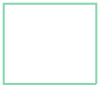

In [61]:
bounds_ref = list(ref_polygon.geometry.total_bounds)

building_GGO = create_box_building("GGO", bounds_ref, 75, -20, 85 , -20)
building_GGO.boundary

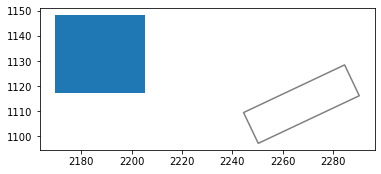

In [62]:
compare_buildings(ref_polygon['geometry'].boundary, building_GGO)

In [63]:
calculate_distance(ref_id, building_GGO )

Distancia entre centroids:
 106    61.592935
0       0.000000
dtype: float64


,geometry,centroid
106,"POLYGON ((2250.349 1097.263, 2290.520 1116.201...",POINT (2267.517 1112.860)
0,"POLYGON ((2205.520 1117.263, 2205.520 1148.459...",POINT (2187.515 1132.861)


(1000.0, 1500.0)

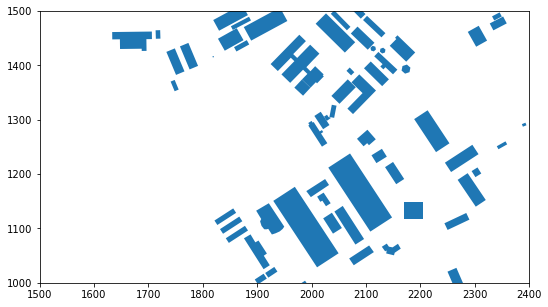

In [64]:
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))

teste = gpd.GeoSeries(building_GGO)
teste.plot(ax=ax) 

# # para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(1500, 2400)
ax.set_ylim(1000, 1500)

In [65]:
add_dataset_rows(mapa_normalizado, building_GGO, 'GGO', 'university')

Novo Shape: (302, 4)


,geometry,osm_id,name,type
301,"POLYGON ((2205.520 1117.263, 2205.520 1148.459...",10000006.0,GGO,university


## Cria e ADD Pontos não encontrados

### IG (parte inferior) e EB

In [66]:
# Tratamento para que prédio do IG e EB não tenham o mesmo centroid do prédio com o ID 554951142

ref_id = 554951142
point_IG = mapa_normalizado.query('osm_id ==' + str(ref_id))
print(point_IG['geometry'].centroid)

# Get Polygon value
# get_polygon_coords(point_IG)

111    POINT (2089.558 1166.068)
dtype: geometry


(1000.0, 1500.0)

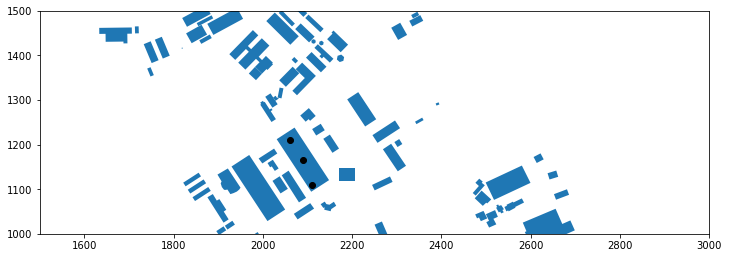

In [67]:
# Reposicionando posicionamento do IG e EB (ao inves de centroid do prédio)
pt_IG = Point(2110, 1110)
pt_EB = Point(2060, 1210)

# Plot de paradas de ÔNIBUS
pt_IG_df = gpd.GeoDataFrame(columns=["geometry"],  crs='EPSG:31983')
pt_IG_df.loc[0, 'geometry'] = pt_IG
pt_IG_df.loc[1, 'geometry'] = Point (2089.558, 1166.068) # point_IG['geometry'].centroid
pt_IG_df.loc[2, 'geometry'] = pt_EB

ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))
pt_IG_df.plot(ax=ax, color="black")

# para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(1500, 3000)
ax.set_ylim(1000, 1500)

### Paradas de Ônibus

In [68]:
# Coordenadas obtidas pelo notebook "Mapa dinâmico"
# Google Maps ajuda nessa parte tb

parada_RM = Point(-47.0677, -22.8242) 
parada_AL = Point(-47.0629, -22.8319) 
parada_VB = Point(-47.0628, -22.8275)

# Convertendo Coordenadas em Degree para metros (31983)
pontos_onibus_df = gpd.GeoDataFrame(columns=["geometry"],  crs='EPSG:4326')
pontos_onibus_df.loc[0, 'geometry'] = parada_RM
pontos_onibus_df.loc[1, 'geometry'] = parada_AL
pontos_onibus_df.loc[2, 'geometry'] = parada_VB
pontos_onibus_df = pontos_onibus_df.to_crs('EPSG:31983')
# pontos_onibus_df.crs
pontos_onibus_df

,geometry
0,POINT (287793.104 7474455.271)
1,POINT (288297.792 7473609.406)
2,POINT (288301.248 7474096.840)


In [69]:
# PONTOS no CRS EPSG:31983
parada_RM = Point(pontos_onibus_df['geometry'][0])
parada_AL = Point(pontos_onibus_df['geometry'][1])
parada_VB = Point(pontos_onibus_df['geometry'][2])

print(parada_RM)
print(parada_AL)
print(parada_VB)

POINT (287793.1041268592 7474455.270733602)
POINT (288297.7924639747 7473609.405694909)
POINT (288301.2480990409 7474096.839670669)


In [70]:
# NORMALIZAÇÃO DE PONTOS 

points = [parada_RM, parada_AL, parada_VB]
norm_points = []

# convert to 2D array 
x = np.array(all_coords_x).reshape(-1, 1) # reshape -> 2D array
y = np.array(all_coords_y).reshape(-1, 1)

for coords in points:
    # convert to 2D array
    x_coords = np.array([coords.x]).reshape(-1, 1)
    y_coords = np.array([coords.y]).reshape(-1, 1)

    # define limits of normalization
    scaler_x = MinMaxScaler(feature_range = (0, unicamp_maxx - unicamp_minx))
    scaler_y = MinMaxScaler(feature_range = (0, unicamp_maxy - unicamp_miny))

    # normalize with all all geometry coords x 
    scaler_x.fit(x)
    transform_x = scaler_x.transform(x_coords)

    # normalize with all all geometry coords y
    scaler_y.fit(y)
    transform_y = scaler_y.transform(y_coords)

    print(transform_x, transform_y)
    norm_points.append(Point(transform_x, transform_y))

print(norm_points[0])

[[1832.38494007]] [[1067.99849656]]
[[2337.07327719]] [[222.13345787]]
[[2340.52891225]] [[709.56743363]]
POINT (1832.384940070857 1067.998496558517)


In [71]:
# p/ Plotar paradas de ÔNIBUS
pontos_onibus_norm_df = gpd.GeoDataFrame(columns=["geometry"],  crs='EPSG:31983')
pontos_onibus_norm_df.loc[0, 'geometry'] = norm_points[0]
pontos_onibus_norm_df.loc[1, 'geometry'] = norm_points[1]
pontos_onibus_norm_df.loc[2, 'geometry'] = norm_points[2]

pontos_onibus_norm_df

,geometry
0,POINT (1832.385 1067.998)
1,POINT (2337.073 222.133)
2,POINT (2340.529 709.567)


<AxesSubplot:>

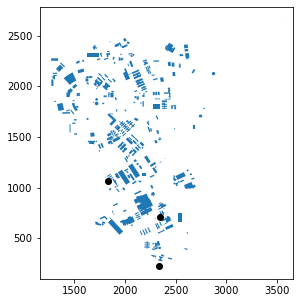

In [72]:
# Plot de paradas de ÔNIBUS
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))
pontos_onibus_norm_df.plot(ax=ax, color="black")

In [73]:
a =  mapa_normalizado.iloc[mapa_normalizado.shape[0]-10: mapa_normalizado.shape[0]]
a

,geometry,osm_id,name,type
292,"POLYGON ((2475.582 1043.396, 2479.730 1034.537...",698317158.0,Editora Unicamp,university
293,"POLYGON ((2500.518 1026.088, 2506.724 1013.990...",698317159.0,Nudecri / Labeurb,university
294,"POLYGON ((2522.389 1058.417, 2528.388 1047.944...",698317160.0,None,university
295,"POLYGON ((2889.450 2125.000, 2889.371 2123.388...",10000000.0,Museu Exploratório,university
296,"POLYGON ((1748.000 2289.589, 1748.000 2323.997...",10000001.0,IG-cima,university
297,"POLYGON ((2344.682 1776.383, 2344.682 1829.005...",10000002.0,CCUEC,university
298,"POLYGON ((2686.934 1574.140, 2686.934 1622.378...",10000003.0,CBMEG,university
299,"POLYGON ((1737.834 1830.674, 1737.748 1828.924...",10000004.0,CBI,university
300,"POLYGON ((2558.121 659.998, 2558.121 753.018, ...",10000005.0,Sergio Porto,school
301,"POLYGON ((2205.520 1117.263, 2205.520 1148.459...",10000006.0,GGO,university


# Criação de dataset dos Prédios da Unicamp

- Create a xml file with Unicamp Building shapes & height
- The outuput xml file will serve as input of NS3

In [74]:
# estudando e tratando a string Polygon
polygon_str = str(mapa_normalizado['geometry'][0])
polygon_coords = polygon_str[polygon_str.find("(") + 2:]
polygon_coords = polygon_coords[ : polygon_coords.find(")")]
polygon_coords

'2219.251139687083 2238.727775357664, 2221.361987684679 2239.787423081696, 2228.596089881903 2225.477409613319, 2190.487653719552 2206.424288934097, 2184.996146517573 2217.280481930822, 2193.215351607127 2221.394112979993, 2185.146765219572 2237.365068141371, 2204.206298525154 2246.880641972646, 2210.521516594803 2234.396566327661, 2214.620936836873 2236.447694022208, 2219.251139687083 2238.727775357664'

In [75]:
# Criando xml dataset
from xml.dom import minidom
import os 
  
root = minidom.Document()
  
xml = root.createElement('additional') 
xml.setAttribute('xmlns:xsi','http://www.w3.org/2001/XMLSchema-instance')
xml.setAttribute('xsi:noNamespaceSchemaLocation','http://sumo.dlr.de/xsd/additional_file.xsd')
root.appendChild(xml)

for i in range(len(mapa_normalizado['geometry'])):   
    
    polygon_str = str(mapa_normalizado['geometry'][i])
    polygon_coords = polygon_str[polygon_str.find("(") + 2:]
    polygon_coords = polygon_coords[ : polygon_coords.find(")")]
    
    productChild = root.createElement('poly')
    productChild.setAttribute('id', str(mapa_normalizado['osm_id'][i]))
    productChild.setAttribute('type', str(mapa_normalizado['type'][i]))
    productChild.setAttribute('color', '255.0,230.0,230.0')
    productChild.setAttribute('layer', '-1.0')
    productChild.setAttribute('fill', '1')
    productChild.setAttribute('height', '6.1')
    productChild.setAttribute('shape', polygon_coords)
  
    xml.appendChild(productChild)
  
xml_str = root.toprettyxml(indent ="\t") 
  
save_path_file = "predios_unicamp_dataset.xml"
  
with open(save_path_file, "w") as f:
    f.write(xml_str) 


In [76]:
print("SHAPE:", mapa_normalizado.shape)

SHAPE: (302, 4)


# Criação de dataset do posicionamento dos Coletores

- Buscar e Mapear predios que contem coletores
    - https://www.prefeitura.unicamp.br/2016/02/26/programa-de-coleta-de-pilhas-e-baterias-instalacao-de-coletores/
    - https://unicamp-arcgis.maps.arcgis.com/apps/View/index.html?appid=1d96ada62af4451bb4972b9779d09e66

- Rotular prédios sem nome
    - Anotar centroids de prédios mapeados
- Criar dataset de posicionamento de nós

## Rotular prédios sem nome

In [77]:
# Dataset de Prédios com coletores
building_label = {
    "163762428":"INOVA",
    "95463723": "BC",
    "10000003": "CBMEG",
    "554951142": "CCS",
    "10000002": "CCUEC",
    "556327645": "GASTROCENTRO",
    "562047735": "CEPETRO",
    "556327636": "HEMOCENTRO",
    "556327686": "CEMEQ",
    "10000004": "CBI",
    "95011161": "CBII",
    "95463720": "CDC",
    "554951141": "DGA",
    "362643631": "DGRH",
    "537155702": "DEdIC",
    "10000005": "Sergio porto",
    "537142892": "FCM",
    "96446654": "FEF",
    "537142893": "FEnf",
    "97592693": "FEAGRI",
    "556327678": "FEC",
    "554951120": "FEA",
    "269851018": "FEEC",
    "554951124": "FEM",
    "554968138": "FEQ",
    "556327623": "FUNCAMP",
    "562047779": "GR",
    "10000006": "GGO", 
    "538334949": "HC",
    "537166697": "IA",
    "95540601": "IB",
    "95011169": "IC",
    "556327698": "IEL",
    "95463722": "IFCH", 
    "556327703": "IFGW",
    "10000001": "IG-CIMA", 
    "95463724": "IMECC",
    "96493946": "IQ",
    "562047775": "PREFEITURA",
    "269851019": "RA",
    "270488633": "RS",
    "95463718": "RU",        
} 

nodes_df = gpd.GeoDataFrame(columns=['osm_id', 'name', 'type', 'geometry', 'centroid'])

# Labeling buildings
aux = 0
for key, value in building_label.items():
    building = mapa_normalizado.query('osm_id ==' + str(key))
    building_n = building.copy()
    building_n.loc[building.index, 'name'] = value
    nodes_df.loc[aux, ['osm_id']] = building_n['osm_id'].values   
    nodes_df.loc[aux, ['name']] = building_n['name'].values    
    nodes_df.loc[aux, ['type']] = building_n['type'].values
    nodes_df.loc[aux, ['geometry']] = building_n['geometry'].values
#     nodes_df.loc[aux, ['centroids']] = building_n['centroids'].values
    
    aux = aux + 1
    
nodes_df.head()
# nodes_df.shape


,osm_id,name,type,geometry,centroid
0,163762428.0,INOVA,None,"POLYGON ((2537.468 2317.065, 2557.548 2318.984...",NaN
1,95463723.0,BC,library,"POLYGON ((1418.961 1897.896, 1451.293 1890.141...",NaN
2,10000003.0,CBMEG,university,"POLYGON ((2686.934 1574.140, 2686.934 1622.378...",NaN
3,554951142.0,CCS,None,"POLYGON ((2030.907 1211.909, 2070.898 1237.890...",NaN
4,10000002.0,CCUEC,university,"POLYGON ((2344.682 1776.383, 2344.682 1829.005...",NaN


In [78]:
nodes_df['centroid'] = nodes_df.centroid
nodes_df.head()

,osm_id,name,type,geometry,centroid
0,163762428.0,INOVA,None,"POLYGON ((2537.468 2317.065, 2557.548 2318.984...",POINT (2555.945 2307.239)
1,95463723.0,BC,library,"POLYGON ((1418.961 1897.896, 1451.293 1890.141...",POINT (1448.467 1935.840)
2,10000003.0,CBMEG,university,"POLYGON ((2686.934 1574.140, 2686.934 1622.378...",POINT (2677.671 1598.259)
3,554951142.0,CCS,None,"POLYGON ((2030.907 1211.909, 2070.898 1237.890...",POINT (2089.558 1166.068)
4,10000002.0,CCUEC,university,"POLYGON ((2344.682 1776.383, 2344.682 1829.005...",POINT (2308.582 1802.694)


<AxesSubplot:>

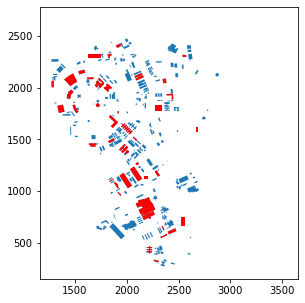

In [79]:
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))

# predios com coletores
nodes_df['geometry'].plot(ax=ax, color="red")

## Criar dataset de posicionamento de nós

In [80]:
# GENERATE BUILDINGS CSV FILE

colunms_names  = ['osm_id', 'name', 'type', 'x', 'y', 'z']


#---- create a csv file
def create_csv(title, colunms_names):
    with open(title,"w+") as file:
        writer = csv.writer(file, delimiter=",")
        writer.writerow(colunms_names)


#---- add row on csv file
def add_csv_rows(ns3_settings, colunms_names, title):
    for colunm in ns3_settings:
        if len(colunm) == len(colunms_names):
            with open(title,"a") as file:
                writer = csv.writer(file, delimiter=",")
                writer.writerow([x for x in colunm])


In [81]:
nodes_pos = []
for i in range(len(nodes_df.geometry)):
    # tratando a string Point
    point_str = str(nodes_df['centroid'][i])
    point_coords = point_str[point_str.find("(") + 1:]
    point_coords = point_coords[ : point_coords.find(")")]
    x = point_coords.split()[0]
    y = point_coords.split()[1]
    z = 1.5

    items_per_row = [nodes_df.loc[i]['osm_id'],
              nodes_df.loc[i]['name'],
              nodes_df.loc[i]['type'],
              x, y, z]
    
    nodes_pos.append(items_per_row)

output_filename = 'coletores_pos_dataset.csv'
create_csv(output_filename, colunms_names)
add_csv_rows(nodes_pos, colunms_names, output_filename)

In [82]:
node_pos_df = pd.read_csv("coletores_pos_dataset.csv") 

print("DATASET SHAPE:", node_pos_df.shape)
node_pos_df.head()

DATASET SHAPE: (42, 6)


,osm_id,name,type,x,y,z
0,163762428.0,INOVA,NaN,2555.945455,2307.239101,1.5
1,95463723.0,BC,library,1448.467151,1935.840334,1.5
2,10000003.0,CBMEG,university,2677.671396,1598.259044,1.5
3,554951142.0,CCS,NaN,2089.558260,1166.067834,1.5
4,10000002.0,CCUEC,university,2308.582297,1802.694367,1.5


## ADD pontos não encontrados

In [83]:
# ADD pontos
add_node_dataset_rows(node_pos_df, "IG-baixo", "university", pt_IG)
add_node_dataset_rows(node_pos_df, "EB", "university", pt_EB)
add_node_dataset_rows(node_pos_df, "PO-RM", "stop_bus", norm_points[0]) # parada_RM
add_node_dataset_rows(node_pos_df, "PO-AL", "stop_bus", norm_points[1]) # parada_AL
add_node_dataset_rows(node_pos_df, "PO-VB", "stop_bus", norm_points[2]) # parada_VB

Novo Shape: (43, 6)
Novo Shape: (44, 6)
Novo Shape: (45, 6)
Novo Shape: (46, 6)
Novo Shape: (47, 6)


,osm_id,name,type,x,y,z
46,10000011.0,PO-VB,stop_bus,2340.528912,709.567434,1.5


In [84]:
view = node_pos_df.iloc[node_pos_df.shape[0]-10:node_pos_df.shape[0]]
view

,osm_id,name,type,x,y,z
37,96493946.0,IQ,NaN,1872.411480,1672.640200,1.5
38,562047775.0,PREFEITURA,NaN,1929.015446,974.247673,1.5
39,269851019.0,RA,restaurant,2100.988849,1265.442596,1.5
40,270488633.0,RS,restaurant,2364.718497,2065.622354,1.5
41,95463718.0,RU,restaurant,1363.622221,1796.177263,1.5
42,10000007.0,IG-baixo,university,2110.000000,1110.000000,1.5
43,10000008.0,EB,university,2060.000000,1210.000000,1.5
44,10000009.0,PO-RM,stop_bus,1832.384940,1067.998497,1.5
45,10000010.0,PO-AL,stop_bus,2337.073277,222.133458,1.5
46,10000011.0,PO-VB,stop_bus,2340.528912,709.567434,1.5


<AxesSubplot:>

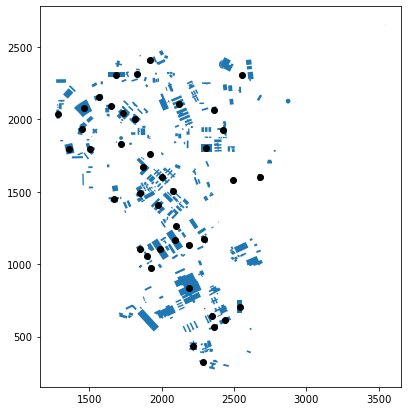

In [85]:
ax = mapa_normalizado['geometry'].plot(figsize=(15, 7))

# centroids
nodes_df["centroid"].plot(ax=ax, color="black")